# allergy

* allergyEnteredOffset
* allergyNoteType
* specialtyType
* userType
* rxIncluded
* writtenIneICU
* drugName
* allergyType
* allergyName
* drugHiclSeqno

We recommend configuring the `config.ini` file to allow for connection to the database without specifying your password each time.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
import pdvega

# for configuring connection 
from configobj import ConfigObj
import os

%matplotlib inline

/home/alistairewj/.local/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = 'localhost'
    conn_info["sqlport"] = 5432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == 'localhost') & (conn_info["sqlport"]=='5432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: alistairewj


## Examine a single patient

In [3]:
patientunitstayid = 287822

In [4]:
query = query_schema + """
select *
from allergy
where patientunitstayid = {}
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df.head()

,allergyid,patientunitstayid,allergyyear,allergytime24,allergytime,allergyoffset,allergyenteredyear,allergyenteredtime24,allergyenteredtime,allergyenteredoffset,allergynotetype,specialtytype,usertype,rxincluded,writtenineicu,drugname,allergytype,allergyname,drughiclseqno
0,223474,287822,2014,22:15:00,midnight,120,2014,22:28:09,midnight,133,Admission,eCM Primary,THC Nurse,True,True,,Non Drug,Nickel,None
1,223475,287822,2014,22:15:00,midnight,120,2014,22:28:09,midnight,133,Admission,eCM Primary,THC Nurse,True,True,,Non Drug,Tetracycline,None
2,223476,287822,2014,22:15:00,midnight,120,2014,22:28:09,midnight,133,Admission,eCM Primary,THC Nurse,True,True,,Non Drug,Ampicillin,None
3,223477,287822,2014,22:15:00,midnight,120,2014,22:28:09,midnight,133,Admission,eCM Primary,THC Nurse,True,True,,Non Drug,Clindamycin,None
4,256993,287822,2014,18:18:00,night,2763,2014,18:18:46,night,2763,Comprehensive Progress,eCM Primary,THC Nurse,False,True,,Non Drug,Nickel,None


In [5]:
# Look at a subset of columns
cols = ['allergyid','patientunitstayid','allergyoffset','allergyenteredoffset',
        'allergynotetype', 'usertype', 'writtenineicu',
       'drugname','allergytype','allergyname']
df[cols].head()

,allergyid,patientunitstayid,allergyoffset,allergyenteredoffset,allergynotetype,usertype,writtenineicu,drugname,allergytype,allergyname
0,223474,287822,120,133,Admission,THC Nurse,True,,Non Drug,Nickel
1,223475,287822,120,133,Admission,THC Nurse,True,,Non Drug,Tetracycline
2,223476,287822,120,133,Admission,THC Nurse,True,,Non Drug,Ampicillin
3,223477,287822,120,133,Admission,THC Nurse,True,,Non Drug,Clindamycin
4,256993,287822,2763,2763,Comprehensive Progress,THC Nurse,True,,Non Drug,Nickel


Here we can see that this patient had an admission note highlighting they were allergic to nickel, tetracycline, ampicillin, and clindamycin.

## Identifying patients allergic to tetracycline

Let's look for patients who were allergic to tetracycline.

In [6]:
drug = 'Tetracycline'
query = query_schema + """
select 
  allergyid, patientunitstayid
  , allergyoffset, allergyenteredoffset
  , allergytype, allergyname
  , drugname, drughiclseqno
from allergy
where allergyname = '{}'
""".format(drug)

df = pd.read_sql_query(query, con)
df.set_index('allergyid',inplace=True)
print('{} unit stays with allergy to {}.'.format(df['patientunitstayid'].nunique(), drug))
df.head()

29 unit stays with allergy to Tetracycline.


,patientunitstayid,allergyoffset,allergyenteredoffset,allergytype,allergyname,drugname,drughiclseqno
allergyid,,,,,,,
223475,287822,120,133,Non Drug,Tetracycline,,None
229693,305743,1643,1645,Non Drug,Tetracycline,,None
229719,300246,86,113,Non Drug,Tetracycline,,None
239070,261530,11,161,Non Drug,Tetracycline,,None
249443,300246,22,23,Non Drug,Tetracycline,,None


However, it's also possible that they used mixed case, pluralization, or specified more than that specific string. We can use a string comparison to look for allergies like tetracycline.

In [7]:
drug = 'Tetracycline'
query = query_schema + """
select 
  allergyid, patientunitstayid
  , allergyoffset, allergyenteredoffset
  , allergytype, allergyname
  , drugname, drughiclseqno
from allergy
where lower(allergyname) like '%{}%'
""".format(drug.lower())

df = pd.read_sql_query(query, con)
df.set_index('allergyid',inplace=True)
print('{} unit stays with allergy to {}.'.format(df['patientunitstayid'].nunique(), drug))
df['allergyname'].value_counts()

752 unit stays with allergy to Tetracycline.


TETRACYCLINE            829
TETRACYCLINE HCL        369
tetracycline             85
Tetracycline             56
OXYTETRACYCLINE          29
tetracyclines            25
Tetracyclines            16
TETRACYCLINES            15
oxytetracycline           4
tetracycline, ultram      3
Tetracycline Base         2
tetracycline base         2
Oxytetracycline           2
PCN, tetracyclines        1
Tetracycline base         1
tetracycline antidep      1
Tetracycline Hcl          1
tetracyclines,            1
tetracyclines and re      1
Name: allergyname, dtype: int64

It's also possible that they specified the allergy under the `drugname` column.

In [8]:
drug = 'Tetracycline'
query = query_schema + """
select 
  allergyid, patientunitstayid
  , allergyoffset, allergyenteredoffset
  , allergytype, allergyname
  , drugname, drughiclseqno
from allergy
where lower(drugname) like '%{}%'
""".format(drug.lower())

df = pd.read_sql_query(query, con)
df.set_index('allergyid',inplace=True)
print('{} unit stays with allergy to {} specified in drugname.'.format(df['patientunitstayid'].nunique(), drug))
print(df['drugname'].value_counts())
df.head()

598 unit stays with allergy to Tetracycline specified in drugname.
TETRACYCLINE        780
TETRACYCLINE HCL    369
OXYTETRACYCLINE      28
Name: drugname, dtype: int64


,patientunitstayid,allergyoffset,allergyenteredoffset,allergytype,allergyname,drugname,drughiclseqno
allergyid,,,,,,,
242969,295698,-774,-773,Drug,TETRACYCLINE,TETRACYCLINE,5236
243647,261622,28,101,Drug,TETRACYCLINE,TETRACYCLINE,5236
268594,292832,29,62,Drug,TETRACYCLINE,TETRACYCLINE,5236
274631,262382,173,189,Drug,TETRACYCLINE,TETRACYCLINE,5236
282195,284979,77,87,Drug,TETRACYCLINE,TETRACYCLINE,5236


Since we may not capture all spellings or brands for tetracycline, we can try to use the HICL code to identify other observations. Above, we can see the HICL for tetracycline is 5236.

In [9]:
hicl = 5236
query = query_schema + """
select 
  allergyid, patientunitstayid
  , allergyoffset, allergyenteredoffset
  , allergytype, allergyname
  , drugname, drughiclseqno
from allergy
where drughiclseqno = {}
""".format(hicl)

df = pd.read_sql_query(query, con)
df.set_index('allergyid',inplace=True)
print('{} unit stays with allergy to HICL {} specified in drugname.'.format(df['patientunitstayid'].nunique(), hicl))
print(df['drugname'].value_counts())
df.head()

344 unit stays with allergy to HICL 5236 specified in drugname.
TETRACYCLINE    780
Name: drugname, dtype: int64


,patientunitstayid,allergyoffset,allergyenteredoffset,allergytype,allergyname,drugname,drughiclseqno
allergyid,,,,,,,
242969,295698,-774,-773,Drug,TETRACYCLINE,TETRACYCLINE,5236
243647,261622,28,101,Drug,TETRACYCLINE,TETRACYCLINE,5236
268594,292832,29,62,Drug,TETRACYCLINE,TETRACYCLINE,5236
274631,262382,173,189,Drug,TETRACYCLINE,TETRACYCLINE,5236
282195,284979,77,87,Drug,TETRACYCLINE,TETRACYCLINE,5236


Let's combine all these methods and summarize how many patients are identified using each method.

In [10]:
hicl = 5236
drugname = 'Tetracycline'
allergyname = 'Tetracycline'
query = query_schema + """
select 
  patientunitstayid
  , max(case when drughiclseqno = {} then 1 else 0 end) as hicl_match
  , max(case when lower(drugname) like '%{}%' then 1 else 0 end) as drug_match
  , max(case when lower(allergyname) like '%{}%' then 1 else 0 end) as allergy_match
from allergy
group by patientunitstayid
""".format(hicl, drugname.lower(), allergyname.lower())

df = pd.read_sql_query(query, con)
# drop non-matching rows
idx = (df['hicl_match'] == 1) | (df['drug_match'] == 1) | (df['allergy_match'] == 1)
df = df.loc[idx, :]

df.groupby(['hicl_match', 'drug_match', 'allergy_match']).count()

patientunitstayid
hicl_match drug_match allergy_match                   
0          0          1                            154
           1          1                            254
1          1          1                            344

As we can see, using the `allergyname` column was the most effective, and always identified patients allergic to tetracycline. Unfortunately we know this is an incomplete search, as likely providers will document brand names rather than generic names from time to time. For example, tetracyclin is marketed under the name Sumycin among others. We can search for Sumycin in the data:

In [11]:
drug = 'Sumycin'
query = query_schema + """
select 
  allergyid, patientunitstayid
  , allergyoffset, allergyenteredoffset
  , allergytype, allergyname
  , drugname, drughiclseqno
from allergy
where lower(allergyname) like '%{}%'
""".format(drug.lower())

df = pd.read_sql_query(query, con)
df.set_index('allergyid',inplace=True)
print('{} unit stays with allergy to {}.'.format(df['patientunitstayid'].nunique(), drug))
df['allergyname'].value_counts()

1 unit stays with allergy to Sumycin.


SUMYCIN    1
Name: allergyname, dtype: int64

Happily, in this case, only 1 patient is excluded by not searching for Sumycin, but in general it may be more.

## Hospitals with data available

In [12]:
query = query_schema + """
select 
  pt.hospitalid
  , count(distinct pt.patientunitstayid) as number_of_patients
  , count(distinct a.patientunitstayid) as number_of_patients_with_tbl
from patient pt
left join allergy a
  on pt.patientunitstayid = a.patientunitstayid
group by pt.hospitalid
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df['data completion'] = df['number_of_patients_with_tbl'] / df['number_of_patients'] * 100.0
df.sort_values('number_of_patients_with_tbl', ascending=False, inplace=True)
df.head(n=10)

,hospitalid,number_of_patients,number_of_patients_with_tbl,data completion
134,338,4277,2453,57.353285
90,243,4243,2241,52.816403
184,420,4679,2127,45.458431
122,300,3617,1936,53.525021
54,167,6092,1854,30.433355
80,208,3650,1700,46.575342
177,411,3199,1623,50.734605
206,458,3701,1611,43.528776
58,176,4328,1508,34.842884
200,443,3656,1240,33.916849


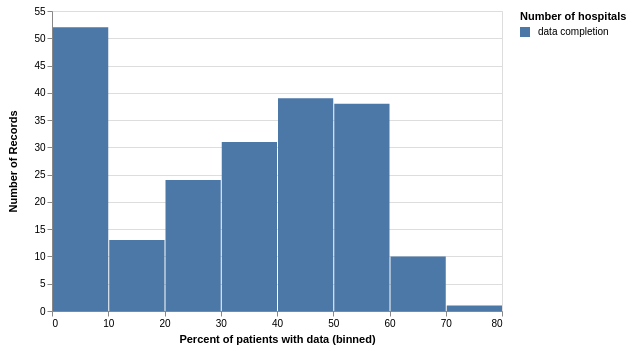

In [13]:
df[['data completion']].vgplot.hist(bins=10,
                                    var_name='Number of hospitals',
                                    value_name='Percent of patients with data')

As is common in eICU-CRD, there are a subset of hospitals who routinely utilize this portion of the medical record (and thus have high data completion), while there are other hospitals who rarely use this interface and thus have poor data completion (0-10%). Data completion is conflated with the fact that not all patients will have an allergy, and thus it is expected that documentation not be >90%.